In [ ]:
!pip install catboost
!pip install shap
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=2c6516c191cdd8ffa773e12c60f32c35dc85e50f511a7799871869db38a4482e
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import joblib
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier, plot_importance
import shap
import lime
import lime.lime_tabular
from catboost import CatBoostClassifier, Pool
%matplotlib inline

In [ ]:
df = pd.read_csv('customer-churn.csv')
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
775,8823-RLPWL,Female,0,Yes,No,72,Yes,Yes,Fiber optic,Yes,...,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),110.65,8065.65,No
6955,5392-AKEMH,Female,0,No,No,12,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,45.05,523.1,No
111,4549-ZDQYY,Female,0,No,No,52,Yes,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,Credit card (automatic),57.95,3042.25,No
2250,0829-DDVLK,Female,0,No,No,15,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),20.10,302.45,No
832,3487-EARAT,Female,0,Yes,Yes,70,Yes,No,DSL,Yes,...,Yes,Yes,No,Yes,One year,No,Credit card (automatic),74.10,5222.3,No


In [ ]:
df.columns


Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
df.drop('customerID', axis = 1 ,inplace = True)
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [ ]:
df.TotalCharges.values

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [ ]:
pd.to_numeric(df.TotalCharges, errors = 'coerce')

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [ ]:
pd.to_numeric(df.TotalCharges, errors = 'coerce').isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Name: TotalCharges, Length: 7043, dtype: bool

In [ ]:
df.shape

(7043, 20)

In [ ]:
df1 = df[df.TotalCharges != " "]
df1.shape

(7032, 20)

In [ ]:
df1.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [ ]:
df1.TotalCharges = pd.to_numeric(df1.TotalCharges)

<ipython-input-12-b67e0c3d31a6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.TotalCharges = pd.to_numeric(df1.TotalCharges)


In [ ]:
df1[['tenure', 'MonthlyCharges', 'TotalCharges']].describe()


,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


In [ ]:
numerical_columns = df1.select_dtypes(include=['number']).columns

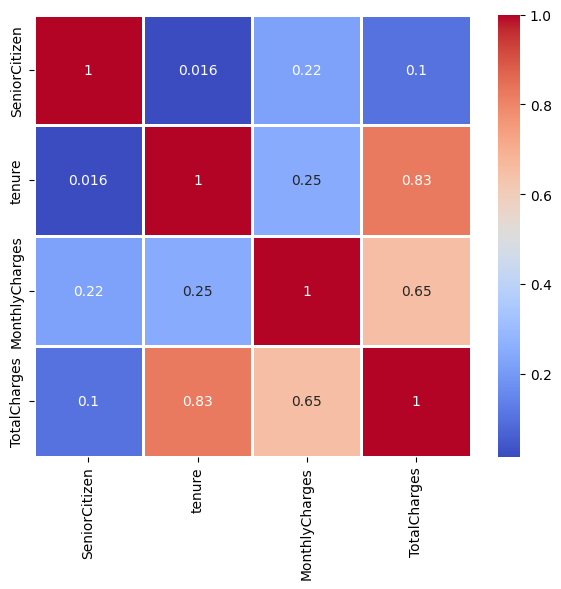

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(
    df1[numerical_columns].corr(),
    annot=True,
    cmap="coolwarm",
    linewidths=2
)

plt.tight_layout()

plt.show()

This correlation heatmap tells the explicit high positive
relationship between tenure and total charges.Also monthly and total charges have obivious positive correlation.


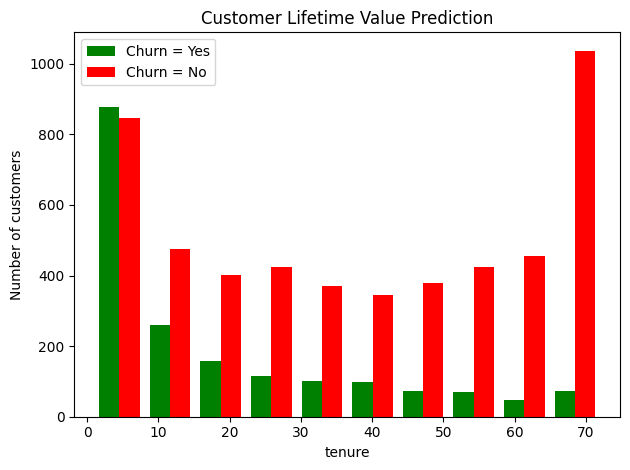

In [ ]:
tenure_churn_no = df1[df1.Churn == 'No'].tenure
tenure_churn_yes = df1[df1.Churn == 'Yes'].tenure

plt.xlabel("tenure")
plt.ylabel("Number of customers")
plt.title('Customer Lifetime Value Prediction')
plt.hist([tenure_churn_yes,tenure_churn_no], color=['green','red'],label =['Churn = Yes','Churn = No'])
plt.legend()

plt.tight_layout()
plt.show()

As the duration of tenure increases the customer churn  decreases significantly

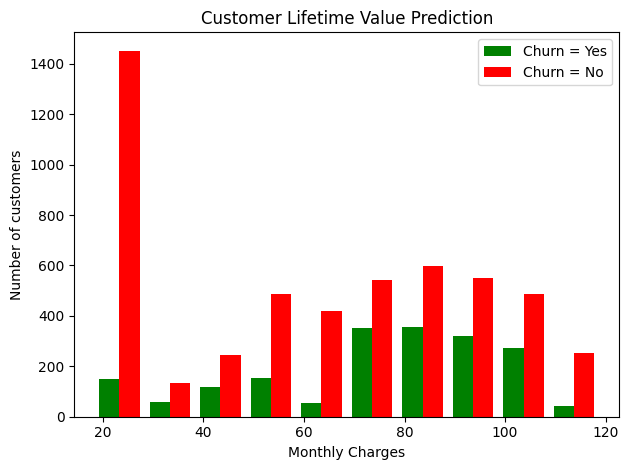

In [ ]:
mc_churn_no = df1[df1.Churn == 'No'].MonthlyCharges
mc_churn_yes = df1[df1.Churn == 'Yes'].MonthlyCharges

plt.xlabel("Monthly Charges")
plt.ylabel("Number of customers")
plt.title('Customer Lifetime Value Prediction')
plt.hist([mc_churn_yes,mc_churn_no], color=['green','red'],label =['Churn = Yes','Churn = No'])
plt.legend()

plt.tight_layout()
plt.show()

As monthly charges increases customer churn pattern is quite uncertain.From graph it is the most when monthly charge is in between 60-80.

In [ ]:
for cols in df:
    print(f'{cols} :  {df[cols].unique()}')

gender :  ['Female' 'Male']
SeniorCitizen :  [0 1]
Partner :  ['Yes' 'No']
Dependents :  ['No' 'Yes']
tenure :  [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService :  ['No' 'Yes']
MultipleLines :  ['No phone service' 'No' 'Yes']
InternetService :  ['DSL' 'Fiber optic' 'No']
OnlineSecurity :  ['No' 'Yes' 'No internet service']
OnlineBackup :  ['Yes' 'No' 'No internet service']
DeviceProtection :  ['No' 'Yes' 'No internet service']
TechSupport :  ['No' 'Yes' 'No internet service']
StreamingTV :  ['No' 'Yes' 'No internet service']
StreamingMovies :  ['No' 'Yes' 'No internet service']
Contract :  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling :  ['Yes' 'No']
PaymentMethod :  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges :  [29.85 56.95 53

In [ ]:
df1.replace('No internet service', 'No', inplace = True)
df1.replace('No phone service', 'No', inplace = True)

<ipython-input-19-4504976d21a6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace('No internet service', 'No', inplace = True)
<ipython-input-19-4504976d21a6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace('No phone service', 'No', inplace = True)


In [ ]:
df1.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No


In [ ]:
df2=df1

In [ ]:
dfnormal=df1

In [ ]:
dfnormal.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No


In [ ]:
df2.replace('Yes',1,inplace=True)
df2.replace('No',0,inplace=True)

<ipython-input-24-ea3c390879af>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.replace('Yes',1,inplace=True)
<ipython-input-24-ea3c390879af>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.replace('No',0,inplace=True)


In [ ]:
df2.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,Male,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,Male,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,Male,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


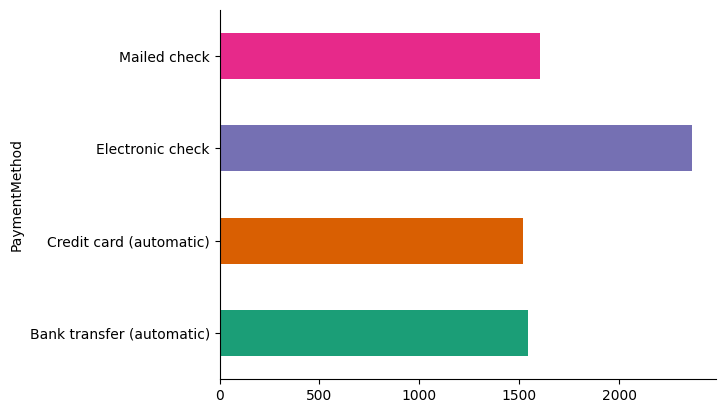

In [ ]:
# @title PaymentMethod

from matplotlib import pyplot as plt
import seaborn as sns
df2.groupby('PaymentMethod').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

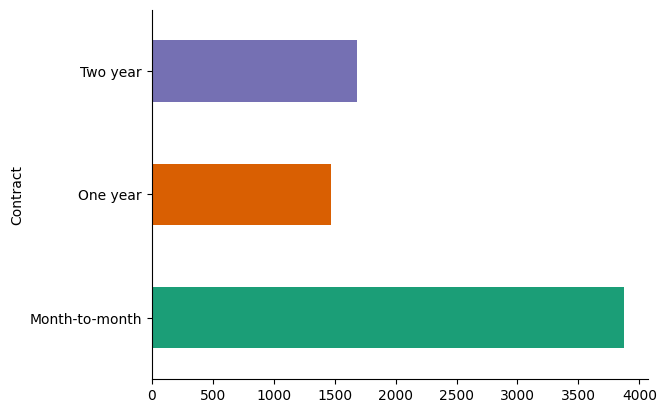

In [ ]:
# @title Contract

from matplotlib import pyplot as plt
import seaborn as sns
df2.groupby('Contract').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

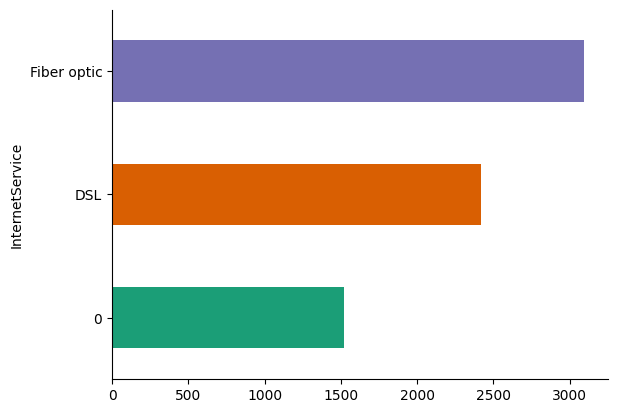

In [ ]:
# @title InternetService

from matplotlib import pyplot as plt
import seaborn as sns
df2.groupby('InternetService').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Most of the cusotmers use:
1.Fiber optic internet service
2.Month to month contract
3.Electronic check payment method

In [ ]:
df2["gender"].replace({'Female':1,'Male':0},inplace = True)

<ipython-input-29-22d215569508>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["gender"].replace({'Female':1,'Male':0},inplace = True)


In [ ]:
df2 = pd.get_dummies(data=df2, columns=['InternetService', 'Contract','PaymentMethod'])
df2

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_0,InternetService_DSL,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,False,True,False,True,False,False,False,False,True,False
1,0,0,0,0,34,1,0,1,0,1,...,False,True,False,False,True,False,False,False,False,True
2,0,0,0,0,2,1,0,1,1,0,...,False,True,False,True,False,False,False,False,False,True
3,0,0,0,0,45,0,0,1,0,1,...,False,True,False,False,True,False,True,False,False,False
4,1,0,0,0,2,1,0,0,0,0,...,False,False,True,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,1,1,24,1,1,1,0,1,...,False,True,False,False,True,False,False,False,False,True
7039,1,0,1,1,72,1,1,0,1,1,...,False,False,True,False,True,False,False,True,False,False
7040,1,0,1,1,11,0,0,1,0,0,...,False,True,False,True,False,False,False,False,True,False
7041,0,1,1,0,4,1,1,0,0,0,...,False,False,True,True,False,False,False,False,False,True


In [ ]:
df2.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'InternetService_0', 'InternetService_DSL',
       'InternetService_Fiber optic', 'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [ ]:
boolean_columns = ['InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_0',
                   'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
                   'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)',
                   'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

df2[boolean_columns] = df2[boolean_columns].astype(int)

print(df2)

      gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0          1              0        1           0       1             0   
1          0              0        0           0      34             1   
2          0              0        0           0       2             1   
3          0              0        0           0      45             0   
4          1              0        0           0       2             1   
...      ...            ...      ...         ...     ...           ...   
7038       0              0        1           1      24             1   
7039       1              0        1           1      72             1   
7040       1              0        1           1      11             0   
7041       0              1        1           0       4             1   
7042       0              0        0           0      66             1   

      MultipleLines  OnlineSecurity  OnlineBackup  DeviceProtection  ...  \
0                 0               0

In [ ]:
df2.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
InternetService_0                            int64
InternetService_DSL                          int64
InternetService_Fiber optic    

In [ ]:
df2.corr()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_0,InternetService_DSL,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
gender,1.000000,0.001819,0.001379,-0.010349,-0.005285,0.007515,0.008883,0.016328,0.013093,0.000807,...,-0.004745,-0.007584,0.011189,0.003251,-0.007755,0.003603,0.015973,-0.001632,-0.000844,-0.013199
SeniorCitizen,0.001819,1.000000,0.016957,-0.210550,0.015683,0.008392,0.142996,-0.038576,0.066663,0.059514,...,-0.182519,-0.108276,0.254923,0.137752,-0.046491,-0.116205,-0.016235,-0.024359,0.171322,-0.152987
Partner,0.001379,0.016957,1.000000,0.452269,0.381912,0.018397,0.142561,0.143346,0.141849,0.153556,...,-0.000286,-0.001043,0.001235,-0.280202,0.083067,0.247334,0.111406,0.082327,-0.083207,-0.096948
Dependents,-0.010349,-0.210550,0.452269,1.000000,0.163386,-0.001078,-0.024307,0.080786,0.023639,0.013900,...,0.138383,0.051593,-0.164101,-0.229715,0.069222,0.201699,0.052369,0.061134,-0.149274,0.056448
tenure,-0.005285,0.015683,0.381912,0.163386,1.000000,0.007877,0.332399,0.328297,0.361138,0.361520,...,-0.037529,0.013786,0.017930,-0.649346,0.202338,0.563801,0.243822,0.232800,-0.210197,-0.232181
PhoneService,0.007515,0.008392,0.018397,-0.001078,0.007877,1.000000,0.279530,-0.091676,-0.052133,-0.070076,...,0.171817,-0.452255,0.290183,-0.001243,-0.003142,0.004442,0.008271,-0.006916,0.002747,-0.004463
MultipleLines,0.008883,0.142996,0.142561,-0.024307,0.332399,0.279530,1.000000,0.098592,0.202228,0.201733,...,-0.210794,-0.200318,0.366420,-0.088558,-0.003594,0.106618,0.075429,0.060319,0.083583,-0.227672
OnlineSecurity,0.016328,-0.038576,0.143346,0.080786,0.328297,-0.091676,0.098592,1.000000,0.283285,0.274875,...,-0.332799,0.320343,-0.030506,-0.246844,0.100658,0.191698,0.094366,0.115473,-0.112295,-0.079918
OnlineBackup,0.013093,0.066663,0.141849,0.023639,0.361138,-0.052133,0.202228,0.283285,1.000000,0.303058,...,-0.380990,0.156765,0.165940,-0.164393,0.084113,0.111391,0.086942,0.090455,-0.000364,-0.174075
DeviceProtection,0.000807,0.059514,0.153556,0.013900,0.361520,-0.070076,0.201733,0.274875,0.303058,1.000000,...,-0.380151,0.145150,0.176356,-0.225988,0.102911,0.165248,0.083047,0.111252,-0.003308,-0.187325


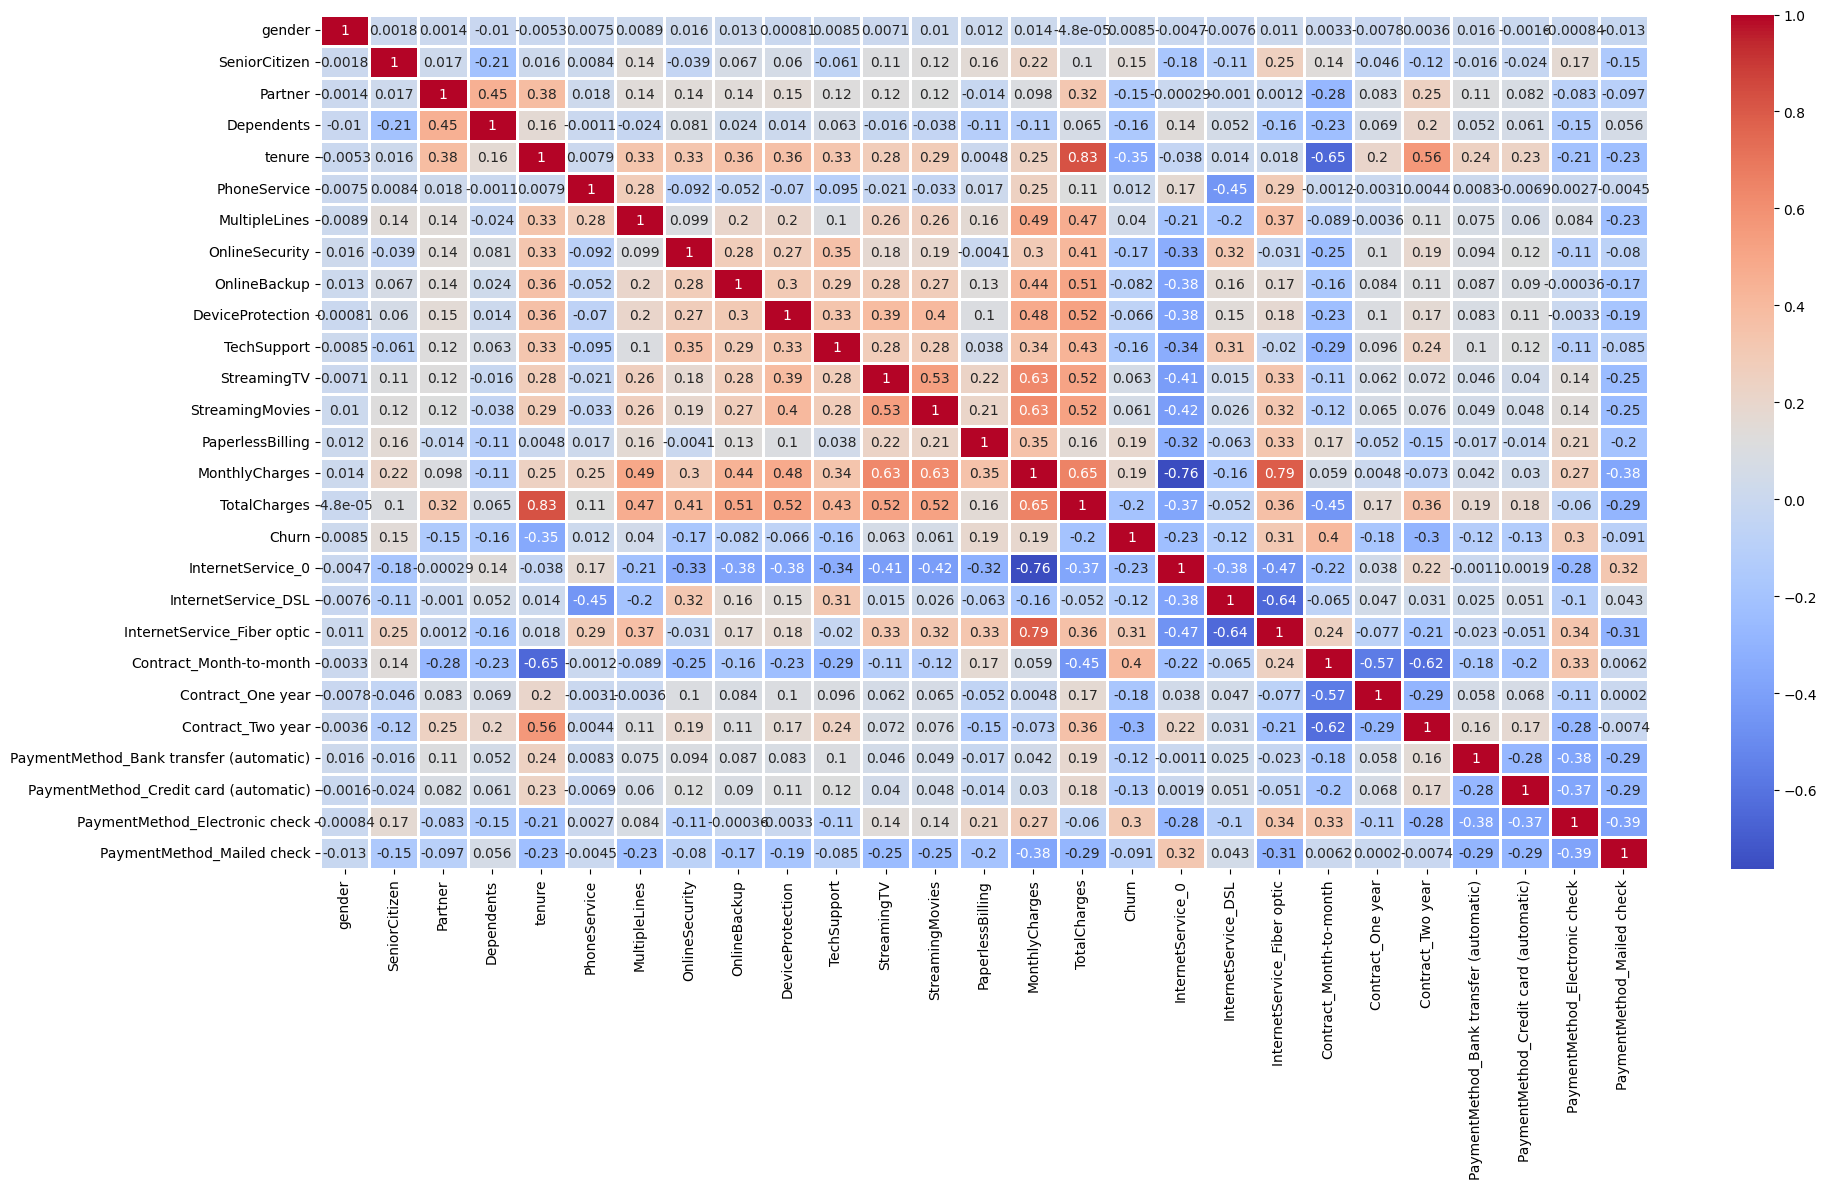

In [ ]:
plt.figure(figsize=(20, 12))
sns.heatmap(
    df2.corr(),
    annot=True,
    cmap="coolwarm",
    linewidths=2
)

plt.tight_layout()

plt.show()


1. Churn Correlation:
Churn has a moderate positive correlation with MonthlyCharges (0.19) and a moderate negative correlation with tenure (-0.35). This suggests that customers with higher monthly charges and shorter tenure are more likely to churn.
Churn also has a moderate positive correlation with InternetService_Fiber optic (0.31) and a moderate negative correlation with InternetService_DSL (-0.17). This indicates that customers using fiber optic internet are more likely to churn compared to those using DSL.
2. Service Correlations:
MonthlyCharges is highly positively correlated with InternetService_Fiber optic (0.71) and negatively correlated with InternetService_No (-0.31). This suggests that fiber optic services are more expensive.
TotalCharges is highly positively correlated with tenure (0.83), which makes sense as longer tenure would accumulate higher total charges.
3. Contract Type:
Contract_Month-to-month has a strong positive correlation with Churn (0.44), while Contract_Two year has a strong negative correlation with Churn (-0.30). This indicates that customers on month-to-month contracts are more likely to churn compared to those on longer-term contracts.
4. Payment Method:
PaymentMethod_Electronic check has a moderate positive correlation with Churn (0.30), suggesting that customers using electronic checks are more likely to churn.
Other payment methods like Bank transfer (automatic), Credit card (automatic), and Mailed check have negative correlations with Churn, indicating lower churn rates for these payment methods.
5. Additional Services:
Features like OnlineSecurity, TechSupport, StreamingTV, and StreamingMovies have moderate negative correlations with Churn, suggesting that customers who subscribe to these additional services are less likely to churn.

General Insights:
High Monthly Charges: Customers with higher monthly charges are more likely to churn.

Short Tenure: Customers with shorter tenure are more likely to churn.

Contract Type: Month-to-month contracts are associated with higher churn rates, while longer-term contracts (one year, two years) are associated with lower churn rates.

Internet Service Type: Fiber optic users are more likely to churn compared to DSL users.

Payment Method: Electronic check users are more likely to churn compared to other payment methods.

Additional Services: Customers who subscribe to additional services like online security, tech support, and streaming services are less likely to churn.

In [ ]:
df2.Churn[df2.Churn ==0].groupby(by = df2.gender).count()

gender
0    2619
1    2544
Name: Churn, dtype: int64

In [ ]:
df2.Churn[df2.Churn ==1].groupby(by = df2.gender).count()

gender
0    930
1    939
Name: Churn, dtype: int64

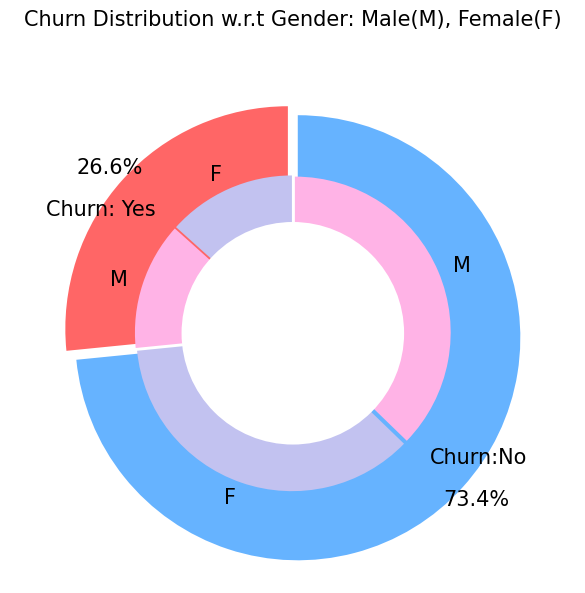

In [ ]:
plt.figure(figsize=(6, 6))
labels =["Churn: Yes","Churn:No"]
values = [1869,5163]
labels_gender = ["F","M","F","M"]
sizes_gender = [939,930 , 2544,2619]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6']
explode = (0.3,0.3)
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Churn Distribution w.r.t Gender: Male(M), Female(F)', fontsize=15, y=1.1)

# show plot

plt.axis('equal')
plt.tight_layout()
plt.show()

There is no much difference in churn rate between males anf females

<ipython-input-39-bb42bfbccbdf>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(df1.MonthlyCharges[(df1["Churn"] == 0) ],
<ipython-input-39-bb42bfbccbdf>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(df1.MonthlyCharges[(df1["Churn"] == 1) ],


Text(0.5, 1.0, 'Distribution of monthly charges by churn')

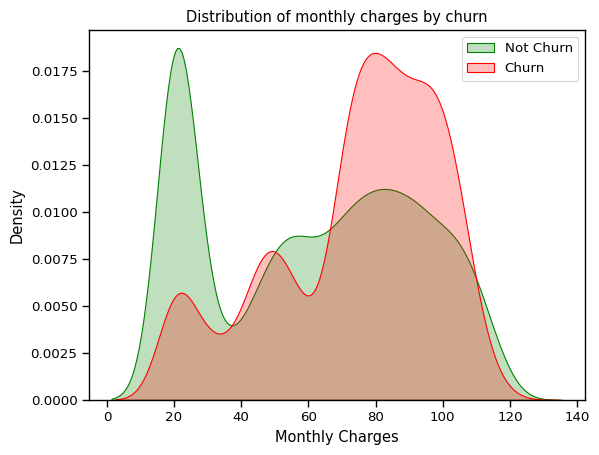

In [ ]:
sns.set_context("paper",font_scale=1.1)
ax = sns.kdeplot(df1.MonthlyCharges[(df1["Churn"] == 0) ],
                color="Green", shade = True);
ax = sns.kdeplot(df1.MonthlyCharges[(df1["Churn"] == 1) ],
                ax =ax, color="Red", shade= True);
ax.legend(["Not Churn","Churn"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Monthly Charges');
ax.set_title('Distribution of monthly charges by churn')

Customers with high monthly charges are likely to churn

<ipython-input-40-320460ed8468>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(df1.TotalCharges[(df1["Churn"] == 0) ],
<ipython-input-40-320460ed8468>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(df1.TotalCharges[(df1["Churn"] == 1) ],


Text(0.5, 1.0, 'Distribution of total charges by churn')

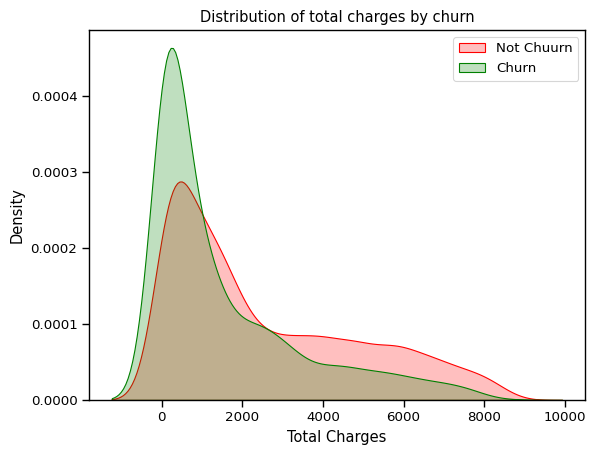

In [ ]:
ax = sns.kdeplot(df1.TotalCharges[(df1["Churn"] == 0) ],
                color="Red", shade = True);
ax = sns.kdeplot(df1.TotalCharges[(df1["Churn"] == 1) ],
                ax =ax, color="Green", shade= True);
ax.legend(["Not Chuurn","Churn"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Total Charges');
ax.set_title('Distribution of total charges by churn')

In [ ]:
fig = px.box(df1, x='Churn', y = 'tenure')

# Update yaxis properties
fig.update_yaxes(title_text='Tenure (Months)', row=1, col=1)
# Update xaxis properties
fig.update_xaxes(title_text='Churn', row=1, col=1)

# Update size and title
fig.update_layout(autosize=True, width=750, height=600,
    title_font=dict(size=25, family='Courier'),
    title='<b>Tenure vs Churn</b>',
)

fig.show()

In [ ]:
df2.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_0,InternetService_DSL,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,0,1,0,1,0,0,0,0,1,0
1,0,0,0,0,34,1,0,1,0,1,...,0,1,0,0,1,0,0,0,0,1
2,0,0,0,0,2,1,0,1,1,0,...,0,1,0,1,0,0,0,0,0,1
3,0,0,0,0,45,0,0,1,0,1,...,0,1,0,0,1,0,1,0,0,0
4,1,0,0,0,2,1,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0


                                    Feature  MI Score
19                  Contract_Month-to-month  0.094959
4                                    tenure  0.075941
21                        Contract_Two year  0.054692
18              InternetService_Fiber optic  0.047512
14                           MonthlyCharges  0.046802
15                             TotalCharges  0.043409
24           PaymentMethod_Electronic check  0.042521
16                        InternetService_0  0.031658
20                        Contract_One year  0.026551
10                              TechSupport  0.022031
3                                Dependents  0.021369
7                            OnlineSecurity  0.016302
11                              StreamingTV  0.014151
17                      InternetService_DSL  0.013416
13                         PaperlessBilling  0.011933
9                          DeviceProtection  0.010380
12                          StreamingMovies  0.010232
2                           

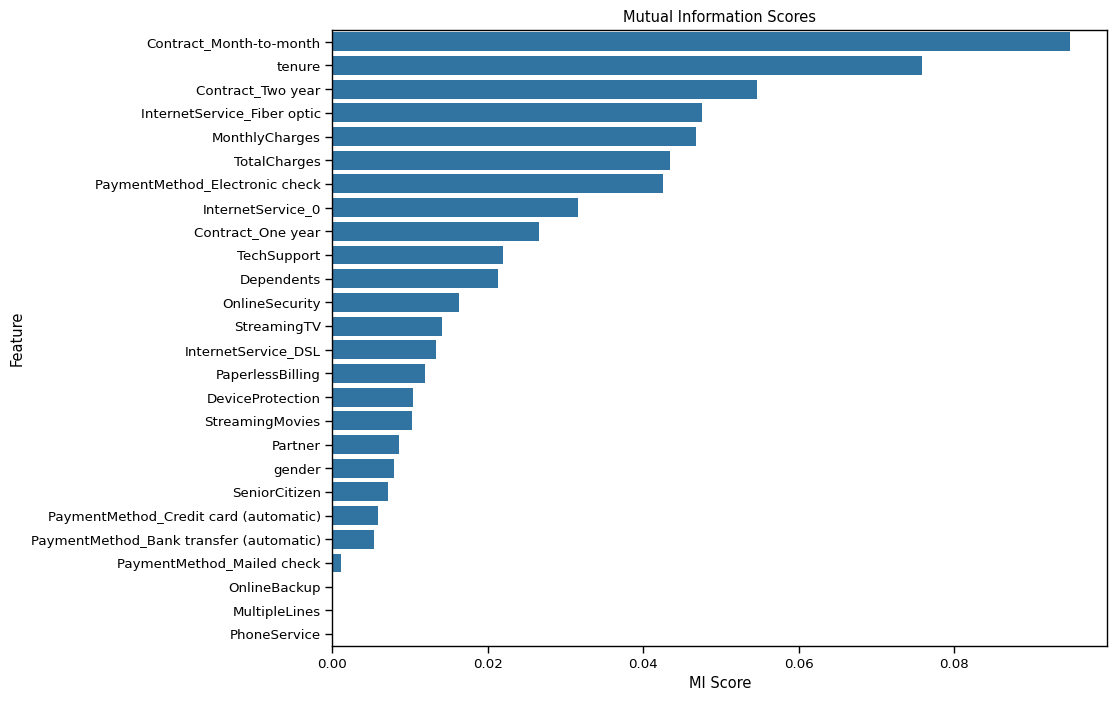

Top 10 features based on mutual information scores: ['Contract_Month-to-month', 'tenure', 'Contract_Two year', 'InternetService_Fiber optic', 'MonthlyCharges', 'TotalCharges', 'PaymentMethod_Electronic check', 'InternetService_0', 'Contract_One year', 'TechSupport']


In [ ]:
X = df2.drop('Churn', axis=1)
y = df2['Churn']

mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=0)

mi_scores_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_scores_df = mi_scores_df.sort_values(by='MI Score', ascending=False)

print(mi_scores_df)
plt.figure(figsize=(10, 8))
sns.barplot(x='MI Score', y='Feature', data=mi_scores_df)
plt.title('Mutual Information Scores')
plt.show()

top_features = mi_scores_df['Feature'].head(10).tolist()
print("Top 10 features based on mutual information scores:", top_features)

In [ ]:
df3=df2[top_features]

In [ ]:
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
x_train,x_test,y_train,y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((6328, 26), (704, 26), (6328,), (704,))

In [ ]:
scale_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train[scale_cols] = scaler.fit_transform(x_train[scale_cols])
x_test[scale_cols] = scaler.transform(x_test[scale_cols])

In [ ]:
#common_columns = x_train.columns.intersection(df3.columns)
#x_train = x_train[common_columns]
#x_test = x_test[common_columns]
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(6328, 26) (704, 26) (6328,) (704,)


In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(15, input_shape=(26,), activation='relu'),
    tf.keras.layers.Dense(15, input_shape=(15,), activation='relu'),
    tf.keras.layers.Dense(15, input_shape=(15,), activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer='rmsprop',
             loss = 'binary_crossentropy',
             metrics=['accuracy'])

model.fit(
    x_train,
    y_train,
    epochs=100
)

Epoch 1/100
198/198 [==============================] - 4s 9ms/step - loss: 0.5085 - accuracy: 0.7547
Epoch 2/100
198/198 [==============================] - 1s 7ms/step - loss: 0.4287 - accuracy: 0.7939
Epoch 3/100
198/198 [==============================] - 1s 7ms/step - loss: 0.4207 - accuracy: 0.7996
Epoch 4/100
198/198 [==============================] - 1s 5ms/step - loss: 0.4173 - accuracy: 0.8044
Epoch 5/100
198/198 [==============================] - 1s 4ms/step - loss: 0.4137 - accuracy: 0.8040
Epoch 6/100
198/198 [==============================] - 1s 4ms/step - loss: 0.4122 - accuracy: 0.8070
Epoch 7/100
198/198 [==============================] - 1s 4ms/step - loss: 0.4112 - accuracy: 0.8067
Epoch 8/100
198/198 [==============================] - 1s 4ms/step - loss: 0.4099 - accuracy: 0.8056
Epoch 9/100
198/198 [==============================] - 1s 7ms/step - loss: 0.4085 - accuracy: 0.8075
Epoch 10/100
198/198 [==============================] - 2s 9ms/step - loss: 0.4076 - accura

In [ ]:
model.save('customer_churn_ANNmodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [ ]:
model.evaluate(x_test, y_test)

22/22 [==============================] - 0s 2ms/step - loss: 0.4722 - accuracy: 0.7770


[0.47218891978263855, 0.7769886255264282]

In [ ]:
yp = model.predict(x_test)
yp[:5]

22/22 [==============================] - 0s 1ms/step


array([[0.21777354],
       [0.0693353 ],
       [0.07881486],
       [0.37426975],
       [0.09372137]], dtype=float32)

In [ ]:
y_pred = []
for i in yp:
    if i > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [ ]:
y_pred = []
for i in yp:
    if i > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [ ]:
y_pred[:5],y_test[:5]

([0, 0, 0, 0, 0],
 2713    0
 1613    0
 2090    0
 5787    1
 6596    0
 Name: Churn, dtype: int64)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       517
           1       0.64      0.43      0.51       187

    accuracy                           0.78       704
   macro avg       0.73      0.67      0.69       704
weighted avg       0.77      0.78      0.77       704



Text(94.91666666666667, 0.5, 'Truth')

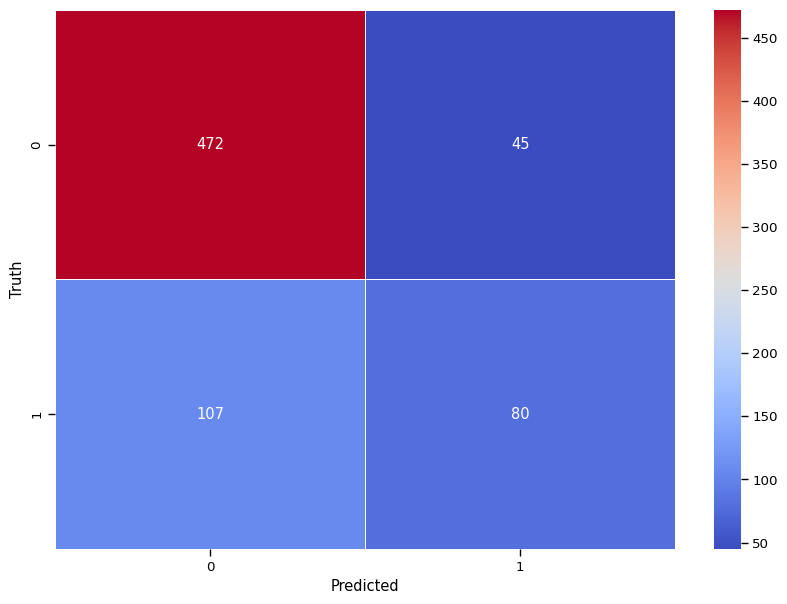

In [ ]:
import seaborn as sns
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='coolwarm',
    linewidths=0.5
)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score
)

In [ ]:
accuracy_score(
    y_test,
    y_pred
)

0.7840909090909091

In [ ]:
recall_score(
    y_test,
    y_pred
)

0.42780748663101603

In [ ]:
precision_score(
    y_test,
    y_pred
)

0.64

In [ ]:
f1_score(
    y_test,
    y_pred
)

0.5128205128205128

In [ ]:
joblib.dump(x_train, 'x_train.pkl')
joblib.dump(y_train, 'y_train.pkl')
joblib.dump(x_test, 'x_test.pkl')
joblib.dump(y_test, 'y_test.pkl')

['y_test.pkl']

In [ ]:
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
x_train.head(5)

,tenure,TechSupport,MonthlyCharges,TotalCharges,InternetService_0,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Electronic check
1443,-1.197269,1,-0.299128,-0.938726,0,0,1,0,0,0
3533,-0.912209,0,-1.496394,-0.919462,1,0,0,1,0,0
2730,0.675981,1,1.392012,1.271393,0,1,0,1,0,0
332,0.553812,0,1.001237,0.942910,0,1,0,1,0,0
1322,-0.912209,0,-1.491406,-0.924091,1,0,1,0,0,0


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from joblib import dump, load

# Define and compile your model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, input_shape=(10,), activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train your model
model.fit(x_train, y_train, epochs=100)

# Save the model
model.save('customer_churn_model.keras')

# Define a preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Fit the preprocessing pipeline
preprocessing_pipeline.fit(x_train)

# Save the preprocessing pipeline and model together
class ModelPipeline:
    def __init__(self, model, preprocessing_pipeline):
        self.model = model
        self.preprocessing_pipeline = preprocessing_pipeline

    def predict(self, X):
        X_preprocessed = self.preprocessing_pipeline.transform(X)
        prediction = self.model.predict(X_preprocessed)
        return prediction

# Create an instance of the combined model and preprocessing pipeline
model_pipeline = ModelPipeline(model, preprocessing_pipeline)

# Save the combined pipeline using joblib
joblib.dump(model_pipeline, 'model_pipeline.pkl')

Epoch 1/100
198/198 [==============================] - 1s 2ms/step - loss: 0.4878 - accuracy: 0.7761
Epoch 2/100
198/198 [==============================] - 0s 2ms/step - loss: 0.4331 - accuracy: 0.7912
Epoch 3/100
198/198 [==============================] - 0s 2ms/step - loss: 0.4264 - accuracy: 0.7931
Epoch 4/100
198/198 [==============================] - 0s 2ms/step - loss: 0.4235 - accuracy: 0.7944
Epoch 5/100
198/198 [==============================] - 0s 2ms/step - loss: 0.4222 - accuracy: 0.7957
Epoch 6/100
198/198 [==============================] - 0s 2ms/step - loss: 0.4209 - accuracy: 0.7957
Epoch 7/100
198/198 [==============================] - 0s 2ms/step - loss: 0.4200 - accuracy: 0.7985
Epoch 8/100
198/198 [==============================] - 0s 2ms/step - loss: 0.4192 - accuracy: 0.7980
Epoch 9/100
198/198 [==============================] - 0s 2ms/step - loss: 0.4188 - accuracy: 0.7987
Epoch 10/100
198/198 [==============================] - 0s 2ms/step - loss: 0.4186 - accura

['model_pipeline.pkl']

CAT BOOST MODEL

In [ ]:
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    eval_metric='Accuracy',
    random_seed=42,
    verbose=200
)

# Train the CatBoost Model
catboost_model.fit(x_train, y_train, eval_set=(x_test, y_test), use_best_model=True)

# Make predictions on the test set
y_pred = catboost_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the CatBoost model: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

0:	learn: 0.7959861	test: 0.7755682	best: 0.7755682 (0)	total: 50.1ms	remaining: 50.1s
200:	learn: 0.8419722	test: 0.7812500	best: 0.7897727 (15)	total: 674ms	remaining: 2.68s
400:	learn: 0.8757901	test: 0.7741477	best: 0.7897727 (15)	total: 2.23s	remaining: 3.33s
600:	learn: 0.8979140	test: 0.7784091	best: 0.7897727 (15)	total: 3.76s	remaining: 2.5s
800:	learn: 0.9165613	test: 0.7656250	best: 0.7897727 (15)	total: 5.23s	remaining: 1.3s
999:	learn: 0.9271492	test: 0.7684659	best: 0.7897727 (15)	total: 5.99s	remaining: 0us

bestTest = 0.7897727273
bestIteration = 15

Shrink model to first 16 iterations.
Accuracy of the CatBoost model: 0.79
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       517
           1       0.64      0.48      0.55       187

    accuracy                           0.79       704
   macro avg       0.73      0.69      0.70       704
weighted avg       0.78      0.79      0.78       704



In [ ]:
catboost_model.save_model('catboost_model.cbm')

In [ ]:
df3.columns

Index(['Contract_Month-to-month', 'tenure', 'Contract_Two year',
       'InternetService_Fiber optic', 'MonthlyCharges', 'TotalCharges',
       'PaymentMethod_Electronic check', 'InternetService_0',
       'Contract_One year', 'TechSupport'],
      dtype='object')

In [ ]:
top_features

['Contract_Month-to-month',
 'tenure',
 'Contract_Two year',
 'InternetService_Fiber optic',
 'MonthlyCharges',
 'TotalCharges',
 'PaymentMethod_Electronic check',
 'InternetService_0',
 'Contract_One year',
 'TechSupport']

In [ ]:
x_train.head(5)

,tenure,TechSupport,MonthlyCharges,TotalCharges,InternetService_0,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Electronic check
1443,-1.197269,1,-0.299128,-0.938726,0,0,1,0,0,0
3533,-0.912209,0,-1.496394,-0.919462,1,0,0,1,0,0
2730,0.675981,1,1.392012,1.271393,0,1,0,1,0,0
332,0.553812,0,1.001237,0.942910,0,1,0,1,0,0
1322,-0.912209,0,-1.491406,-0.924091,1,0,1,0,0,0


In [ ]:
from joblib import load

# Assuming ModelPipeline is already imported
model_pipeline = load('model_pipeline.pkl')
print(model_pipeline)

In [ ]:
df3.to_parquet('df3.parquet')

In [ ]:
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.to_parquet('dfnew.parquet')

In [ ]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
Xnew = df.drop('Churn', axis=1)
ynew = df['Churn']


In [ ]:
X_train,X_test,Y_train,Y_test =train_test_split(Xnew, ynew, stratify=ynew, test_size=0.1, random_state=42)

In [ ]:
joblib.dump(X_train, 'X_train.pkl')
joblib.dump(Y_train, 'Y_train.pkl')
joblib.dump(X_test, 'X_test.pkl')
joblib.dump(Y_test, 'Y_test.pkl')

['Y_test.pkl']

In [ ]:
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=64)

train_index, test_index = next(strat_split.split(df, df["Churn"]))

# Create train and test sets
strat_train_set = df.loc[train_index]
strat_test_set = df.loc[test_index]

# Proportion of the target variable in the original data set
print('Target Labels Ratio in Original Dataset\n')
print(df["Churn"].value_counts(normalize=True).sort_index())

# Proportion of the target variable in the test set
print('\nTarget Labels Ratio in Test Dataset\n')
print(strat_test_set["Churn"].value_counts(normalize=True).sort_index())

X1_train = strat_train_set.drop("Churn", axis=1)
Y1_train = strat_train_set["Churn"].copy()

X1_test = strat_test_set.drop("Churn", axis=1)
Y1_test = strat_test_set["Churn"].copy()

Target Labels Ratio in Original Dataset

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

Target Labels Ratio in Test Dataset

Churn
No     0.734564
Yes    0.265436
Name: proportion, dtype: float64
